# Imports

In [1]:
from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import pandas as pd

d:\Work\movie-recommendation-system\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Datasets

In [2]:
# Read the dataset from tfds
ratings = tfds.load('movielens/latest-small-ratings', split='train')

# Select the needed feature
# x['features'] can be done because the dataset are in form of FeaturesDict, check the docs
ratings = ratings.map(lambda x: {
    'user_id': x['user_id'],        
    'movie_title': x['movie_title'],
    'user_rating': x['user_rating']
    })

# Randomize the dataset
tf.random.set_seed(20)
shuffled = ratings.shuffle(100000, seed=20, reshuffle_each_iteration=False)

train = shuffled.take(80000)
test = shuffled.skip(80000).take(20000)

If your dataset are from csv, you can convert that to TF dataset. Below is an example of its implementation.

``` python
# Import ratings and movies data
ratings = pd.read_csv("data/ratings_200k.csv")
movies = pd.read_csv('data/movies_2000.csv')

# Get movie title to ratings DF
ratings = pd.merge(ratings, movies[['movieId', 'title']], on='movieId')[['userId', 'title', 'rating']]

# Convert value to byte
ratings = ratings.apply(lambda x: x.apply(lambda y: str(y).encode()))

# Convert DF to TF dataset
ratings = tf.data.Dataset.from_tensor_slices(ratings)

# Map so each row can be called by its name
ratings = ratings.map(lambda x: {
    'userId': x[0],
    'title': x[1],
    'rating': float(b'2.5')})
```

In [4]:
# Get unique movie title and user id lists to be used as vocabulary
movie_titles = ratings.batch(1000000).map(lambda x: x['movie_title'])
user_ids = ratings.batch(1000000).map(lambda x: x['movie_title'])

uniq_movie_title = np.unique(np.concatenate(list(movie_titles)))
uniq_user_id = np.unique(np.concatenate(list(user_ids)))

In [5]:
# Define the ranking model
class RankingModel(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        embedding_dims = 32

        # User embedding model        
        self.movie_embedding = tf.keras.models.Sequential([
            tf.keras.layers.StringLookup(vocabulary=uniq_movie_title),
            tf.keras.layers.Embedding(len(uniq_movie_title) + 1, embedding_dims)
        ])

        # Movie embedding model
        self.user_embedding = tf.keras.models.Sequential([
            tf.keras.layers.StringLookup(vocabulary=uniq_user_id),
            tf.keras.layers.Embedding(len(uniq_user_id) + 1, embedding_dims)
        ])

        # Rating prediction model
        self.rating = tf.keras.models.Sequential([
            tf.keras.layers.Dense(256, 'relu'),
            tf.keras.layers.Dense(64, 'relu'),
            tf.keras.layers.Dense(1) # This will output the predicted rating
        ])

    def call(self, inputs):
        user_id, movie_title = inputs

        user_embedding = self.user_embedding(user_id)
        movie_embedding = self.movie_embedding(movie_title)

        return self.rating(tf.concat([user_embedding, movie_embedding], axis=1)) 


In [6]:
# Define movie recommender model
class MovieRecModel(tfrs.Model):
    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def call(self, inputs: Dict[Text, tf.Tensor]):
        return self.ranking_model((inputs['user_id'], inputs['movie_title']))
        

    def compute_loss(self, inputs: Dict[Text, tf.Tensor], training: bool = False) -> tf.Tensor:
        rating_prediction = self.ranking_model((inputs['user_id'], inputs['movie_title']))

        return self.task(labels=inputs['user_rating'], predictions=rating_prediction)

In [27]:
# Compile the model
model = MovieRecModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Cache the dataset
cached_train = train.batch(10000).cache()
cached_test = test.batch(5000).cache()

# Fit the model to train dataset
model.fit(cached_train, epochs=50)

Epoch 1/50
8/8 [==============================] - 2s 58ms/step - root_mean_squared_error: 2.7057 - loss: 6.6558 - regularization_loss: 0.0000e+00 - total_loss: 6.6558
Epoch 2/50
8/8 [==============================] - 0s 40ms/step - root_mean_squared_error: 1.1737 - loss: 1.3490 - regularization_loss: 0.0000e+00 - total_loss: 1.3490
Epoch 3/50
8/8 [==============================] - 0s 40ms/step - root_mean_squared_error: 1.0470 - loss: 1.0945 - regularization_loss: 0.0000e+00 - total_loss: 1.0945
Epoch 4/50
8/8 [==============================] - 0s 39ms/step - root_mean_squared_error: 1.0391 - loss: 1.0795 - regularization_loss: 0.0000e+00 - total_loss: 1.0795
Epoch 5/50
8/8 [==============================] - 0s 47ms/step - root_mean_squared_error: 1.0381 - loss: 1.0775 - regularization_loss: 0.0000e+00 - total_loss: 1.0775
Epoch 6/50
8/8 [==============================] - 0s 39ms/step - root_mean_squared_error: 1.0372 - loss: 1.0757 - regularization_loss: 0.0000e+00 - total_loss: 1.075

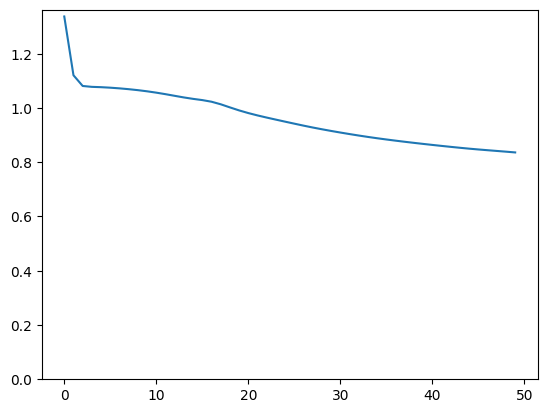

In [28]:
# Plot the loss if necessary
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
sns.lineplot(model.history.history['total_loss'])
ax.set_ylim(0)
plt.show()

In [29]:
# Evaluate model
model.evaluate(cached_test, return_dict=True)

4/4 [==============================] - 1s 20ms/step - root_mean_squared_error: 0.9666 - loss: 0.9327 - regularization_loss: 0.0000e+00 - total_loss: 0.9327


{'root_mean_squared_error': 0.9666138887405396,
 'loss': 0.9260959029197693,
 'regularization_loss': 0,
 'total_loss': 0.9260959029197693}

In [85]:
# Inference testing those movies for user 20
rating_result = {}
movies_to_test = pd.read_csv("retrieved_titles.csv")['0'].values # You can get these list of movies from the retrieval model
for title in movies_to_test:
    rating_result[title] =\
        model({'user_id': np.array(['20']),
               'movie_title': np.array([title])})

rating_result = dict(sorted(rating_result.items(), key=lambda item: item[1], reverse=True)[:5])
print("Predicted ratings")
for i, x in enumerate(rating_result.items()):
    if i < 5:
        print(f"{x[0]}: {x[1][0][0]:.2f}")

Predicted ratings
Finding Forrester (2000): 3.89
State and Main (2000): 3.88
Billy Elliot (2000): 3.88
Recess: School's Out (2001): 3.86
Muppet Christmas Carol, The (1992): 3.86


In [86]:
import os

path = os.path.join(os.curdir, "rating_model")
# Save the model
# This model accept user ID and movie title, and output a rating prediction that will be given by the user to the movie
tf.saved_model.save(model, path)

INFO:tensorflow:Assets written to: .\rating_model\assets


INFO:tensorflow:Assets written to: .\rating_model\assets
